# Diabetes Challenge

Your task today is to **analyze** the Kaggle "Pima Indians Diabetes Database" and to **predict** whether a patient has Diabetes or not.

## Task:
- Load the data from the database. The schema is called `diabetes`. To connect to the database you need to copy the `.env` file from the visualization or hands-on-ml repository into this repo. Explore the database, try to establish what the relationships between the tables are (1-1, 1-N, N-M). Explain to yourself and the group what data do you see and whether it makes sense. What JOINs are appropriate to use and why? 
- Use at least two different classification algorithms we have learned so far to predict Diabetes patients. 
- Discuss before you start with the modeling process which **evaluation metric** you choose and explain why.
- Implement a GridSearchCV or RandomizedSearchCV to tune the hyperparameters of your model.
- **Optional:** If you have time at the end, try to use sklearn's pipline module to encapsulate all the steps into a pipeline.

Don't forget to split your data in train and test set. And analyze your final model on the test data. It might also be necessary to scale your data in order to improve the performance of some of the models.


## Helpful links and advise:
- [sklearn documentation on hyperparameter tuning](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)
- It might be helpful to check some sources on how to deal with imbalanced data. 
    * [8 Tactics to Combat Imbalanced Classes](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)
    * [Random-Oversampling/Undersampling](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/)


# Data Description

## Context
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

## Acknowledgements
Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.

## About this dataset
The datasets consist of several medical predictor (independent) variables and one target (dependent) variable, Outcome. Independent variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on. For the outcome class value 1 is interpreted as "tested positive for diabetes".

|Column Name| Description|
|:------------|:------------|
|Pregnancies|Number of times pregnant|
|Glucose|Plasma glucose concentration a 2 hours in an oral glucose tolerance test|
|BloodPressure|Diastolic blood pressure (mm Hg)|
|SkinThickness|Triceps skin fold thickness (mm)|
|Insulin|2-Hour serum insulin (mu U/ml)|
|BMI|Body mass index (weight in kg/(height in m)^2)|
|DiabetesPedigreeFunction|  a function which scores likelihood of diabetes based on family history|
|Age| Age (years)|
|Outcome|Class variable (0 or 1) |

In [1]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import seaborn as sns

import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score

from sklearn.linear_model import LogisticRegression

from sklearn import set_config
set_config(transform_output="pandas")

# Set random seed 
RSEED = 42

warnings.filterwarnings("ignore")

In [3]:
# Read database string from .env file (no need to change anything)
load_dotenv()

DB_STRING = os.getenv('DB_STRING')

db = create_engine(DB_STRING)

In [9]:
# import the data into a pandas dataframe
query_string_1 = """

SET SCHEMA 'diabetes';


select p.pregnancies, p."Age" , p.bmi, po.diabetespedigreefunction pedigree_f, po.outcome, s.skinthickness, bm.insulin, bm.glucose, bm.bloodpressure  from patient p
left join pedigree_outcome po on po.patientid = p.id
left join skin s on s.patientid = p.id
left join blood_metrics bm on bm.patientid = p.id
where measurement_date = '2022-12-13'


"""
df = pd.read_sql(query_string_1, db)

#export the data to a csv-file
df.to_csv('df_diabetes.csv',index=False)
df

,pregnancies,Age,bmi,pedigree_f,outcome,skinthickness,insulin,glucose,bloodpressure
0,6,50,33.6,1,1,35,0,148,72
1,1,31,26.6,0,0,29,0,85,66
2,8,32,23.3,1,1,0,0,183,64
3,1,21,28.1,0,0,23,94,89,66
4,0,33,43.1,2,1,35,168,137,40
...,...,...,...,...,...,...,...,...,...
763,10,63,32.9,0,0,48,180,101,76
764,2,27,36.8,0,0,27,0,122,70
765,5,30,26.2,0,0,23,112,121,72
766,1,47,30.1,0,1,0,0,126,60


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pregnancies    768 non-null    int64  
 1   Age            768 non-null    int64  
 2   bmi            768 non-null    float64
 3   pedigree_f     768 non-null    int64  
 4   outcome        768 non-null    int64  
 5   skinthickness  768 non-null    int64  
 6   insulin        768 non-null    int64  
 7   glucose        768 non-null    int64  
 8   bloodpressure  768 non-null    int64  
dtypes: float64(1), int64(8)
memory usage: 54.1 KB


In [11]:
df.isnull().sum()

pregnancies      0
Age              0
bmi              0
pedigree_f       0
outcome          0
skinthickness    0
insulin          0
glucose          0
bloodpressure    0
dtype: int64

In [12]:
df.describe()

,pregnancies,Age,bmi,pedigree_f,outcome,skinthickness,insulin,glucose,bloodpressure
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,33.240885,31.992578,0.373698,0.348958,20.536458,79.799479,120.894531,69.105469
std,3.369578,11.760232,7.884160,0.510322,0.476951,15.952218,115.244002,31.972618,19.355807
min,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,24.000000,27.300000,0.000000,0.000000,0.000000,0.000000,99.000000,62.000000
50%,3.000000,29.000000,32.000000,0.000000,0.000000,23.000000,30.500000,117.000000,72.000000
75%,6.000000,41.000000,36.600000,1.000000,1.000000,32.000000,127.250000,140.250000,80.000000
max,17.000000,81.000000,67.100000,2.000000,1.000000,99.000000,846.000000,199.000000,122.000000


Data looks good, no cleaning necessary

Correlation heatmap:

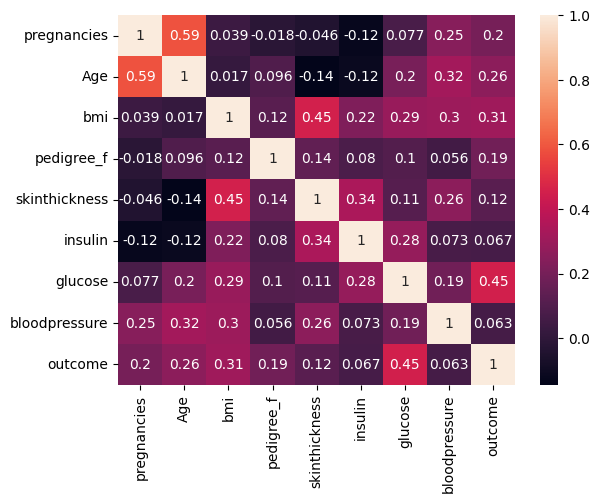

In [80]:
#correlation plot
ax = sns.heatmap(df_test.corr(), annot=True) 

# Modelling:

In [127]:
# Defining X and y

X = df.drop('outcome', axis=1)
y = df['outcome']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

# Making df_train and df_test dataframes:
df_train = pd.concat([X_train,y_train], axis=1)
df_test = pd.concat([X_test,y_test], axis=1)


# Check the shape of the data sets
print("X_train:", X_train.shape)  
print("y_train:", y_train.shape)   
print("X_test:", X_test.shape)  
print("y_test:", y_test.shape)       

X_train: (537, 8)
y_train: (537,)
X_test: (231, 8)
y_test: (231,)


In [128]:
df_test

,pregnancies,Age,bmi,pedigree_f,skinthickness,insulin,glucose,bloodpressure,outcome
730,3,34,28.4,0,23,79,130,78,1
198,4,26,34.8,1,44,99,109,64,1
24,11,51,36.6,0,33,146,143,94,1
417,4,37,38.5,1,32,0,144,82,1
387,8,45,43.3,0,36,0,105,100,1
...,...,...,...,...,...,...,...,...,...
94,2,21,24.7,1,18,64,142,82,0
437,5,28,29.9,0,0,0,147,75,0
86,13,45,36.6,0,54,0,106,72,0
221,2,66,31.6,1,0,0,158,90,1


In [58]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 537 entries, 209 to 107
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pregnancies    537 non-null    int64  
 1   Age            537 non-null    int64  
 2   bmi            537 non-null    float64
 3   pedigree_f     537 non-null    int64  
 4   skinthickness  537 non-null    int64  
 5   insulin        537 non-null    int64  
 6   glucose        537 non-null    int64  
 7   bloodpressure  537 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 37.8 KB


# Logistic regression:

Accuracy on train set: 0.76
Accuracy on test set: 0.77
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       150
           1       0.66      0.70      0.68        81

    accuracy                           0.77       231
   macro avg       0.74      0.75      0.75       231
weighted avg       0.77      0.77      0.77       231

--------------------------------------------------------------------------------


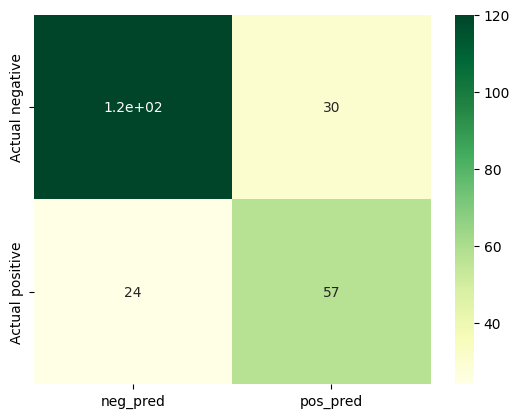

In [129]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")
log_reg.fit(X_train, y_train)

y_pred_train = log_reg.predict(X_train) 
y_pred = log_reg.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred), 2))  
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

# Print confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn', 
yticklabels =['Actual negative', 'Actual positive'], xticklabels =['neg_pred', 'pos_pred']);

Not bad, a better [1] recall would be nice though, GridSearch might be worth trying

### GridSearchCV hyperparameter optimization for logistic regression:


# Decision trees: 
## (Regression and classification)

### Regression:

In [48]:
# import the regressor 
from sklearn.tree import DecisionTreeRegressor 

# create a regressor object 
dec_tree = DecisionTreeRegressor(
            max_depth = 5)  
  
# fit the regressor with X and Y data 
dec_tree.fit(X_train, y_train) 

DecisionTreeRegressor(max_depth=5)

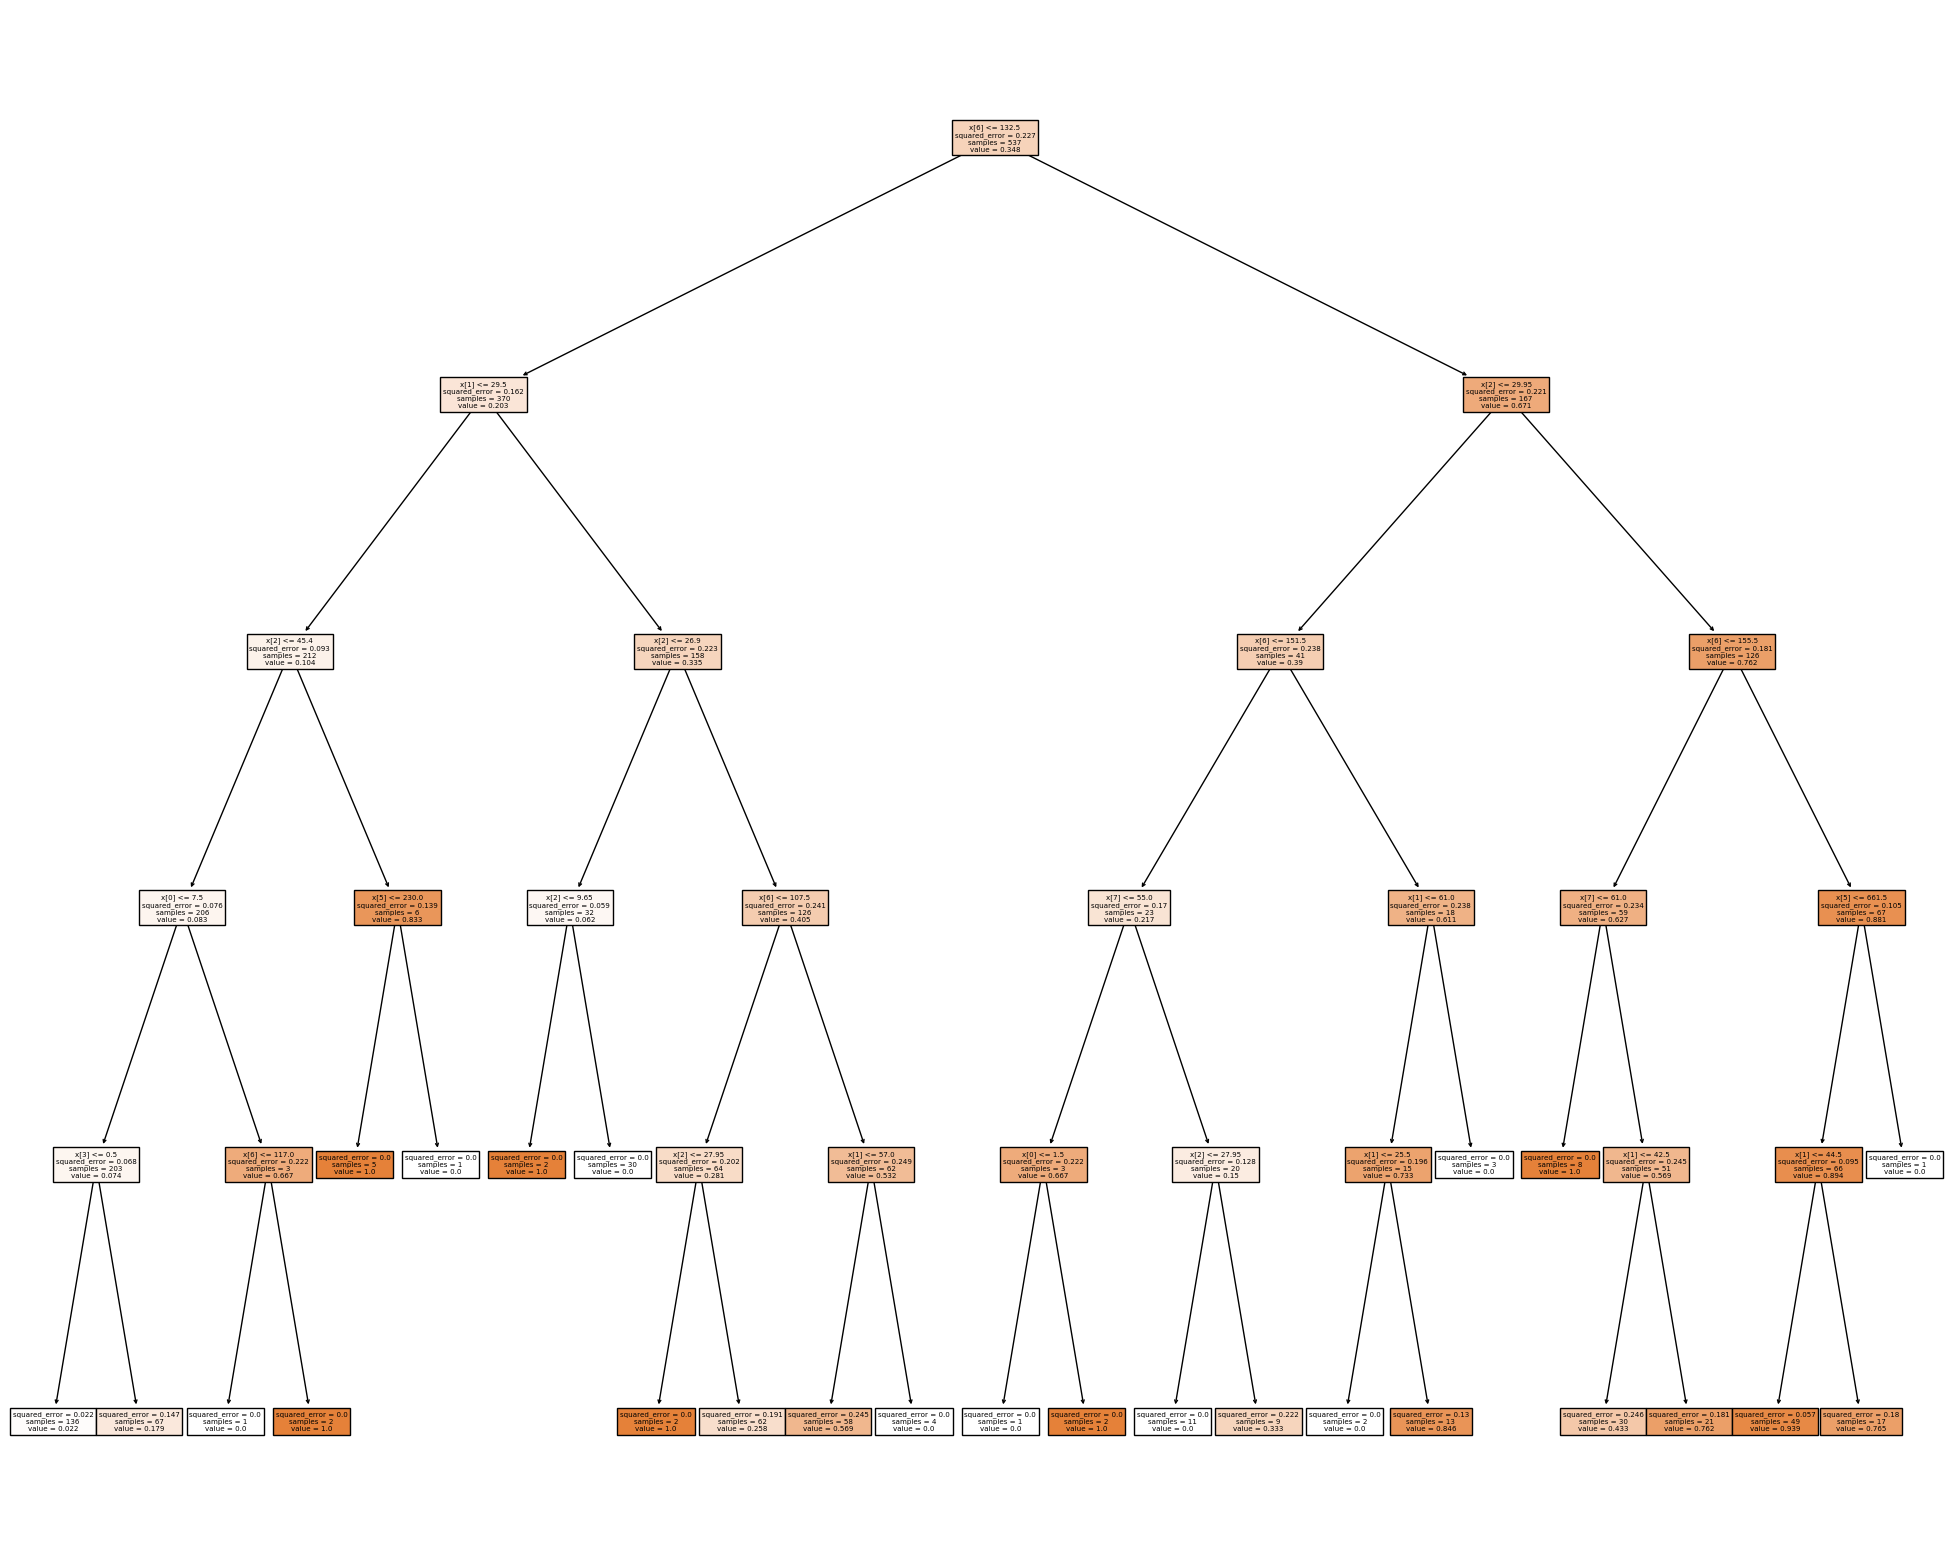

In [49]:
# import necessary library  
from sklearn.tree import plot_tree
  
fig = plt.figure(figsize=(25,20))
dectree_plot = plot_tree(dec_tree, filled=True)

In [59]:
y_pred_train = dec_tree.predict(X_train) 
y_pred = dec_tree.predict(X_test) 
print(y_pred.dtype)
print(y_pred.dtype)

float64
float64


In [60]:
print(y_test.dtype)
print(y_train.dtype)

int64
int64


In [61]:
# Convert predicted values to integers
y_pred_train_int = np.round(y_pred_train).astype(int)
y_pred_int = np.round(y_pred).astype(int)

Accuracy on train set: 0.84
Accuracy on test set: 0.81
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       150
           1       0.79      0.64      0.71        81

    accuracy                           0.81       231
   macro avg       0.81      0.77      0.79       231
weighted avg       0.81      0.81      0.81       231

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


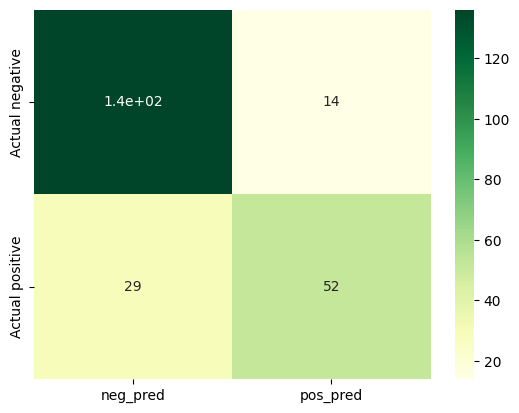

In [132]:
y_pred_train = dec_tree.predict(X_train) 
y_pred = dec_tree.predict(X_test) 
# Convert predicted values to integers
y_pred_train_int = np.round(y_pred_train).astype(int)
y_pred_int = np.round(y_pred).astype(int)

# Print accuracy of our model for test and train set
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train_int), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_int), 2))
print("--------"*10)

# Print classification report of our model 
print(classification_report(y_test, y_pred_int))
print("--------"*10)

print("--------"*10)# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred_int)

# Print confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_int), annot=True, cmap='YlGn', 
yticklabels =['Actual negative', 'Actual positive'], xticklabels =['neg_pred', 'pos_pred']);

Overall accuracy better than unoptimized log reg, but [1] recall as important parameter is worse

### Classification:

In [81]:
from sklearn.tree import DecisionTreeClassifier

 # Creating the classifier object
clf_gini = DecisionTreeClassifier(
            criterion = "gini", 
            max_depth = 5) 
# Performing training 
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

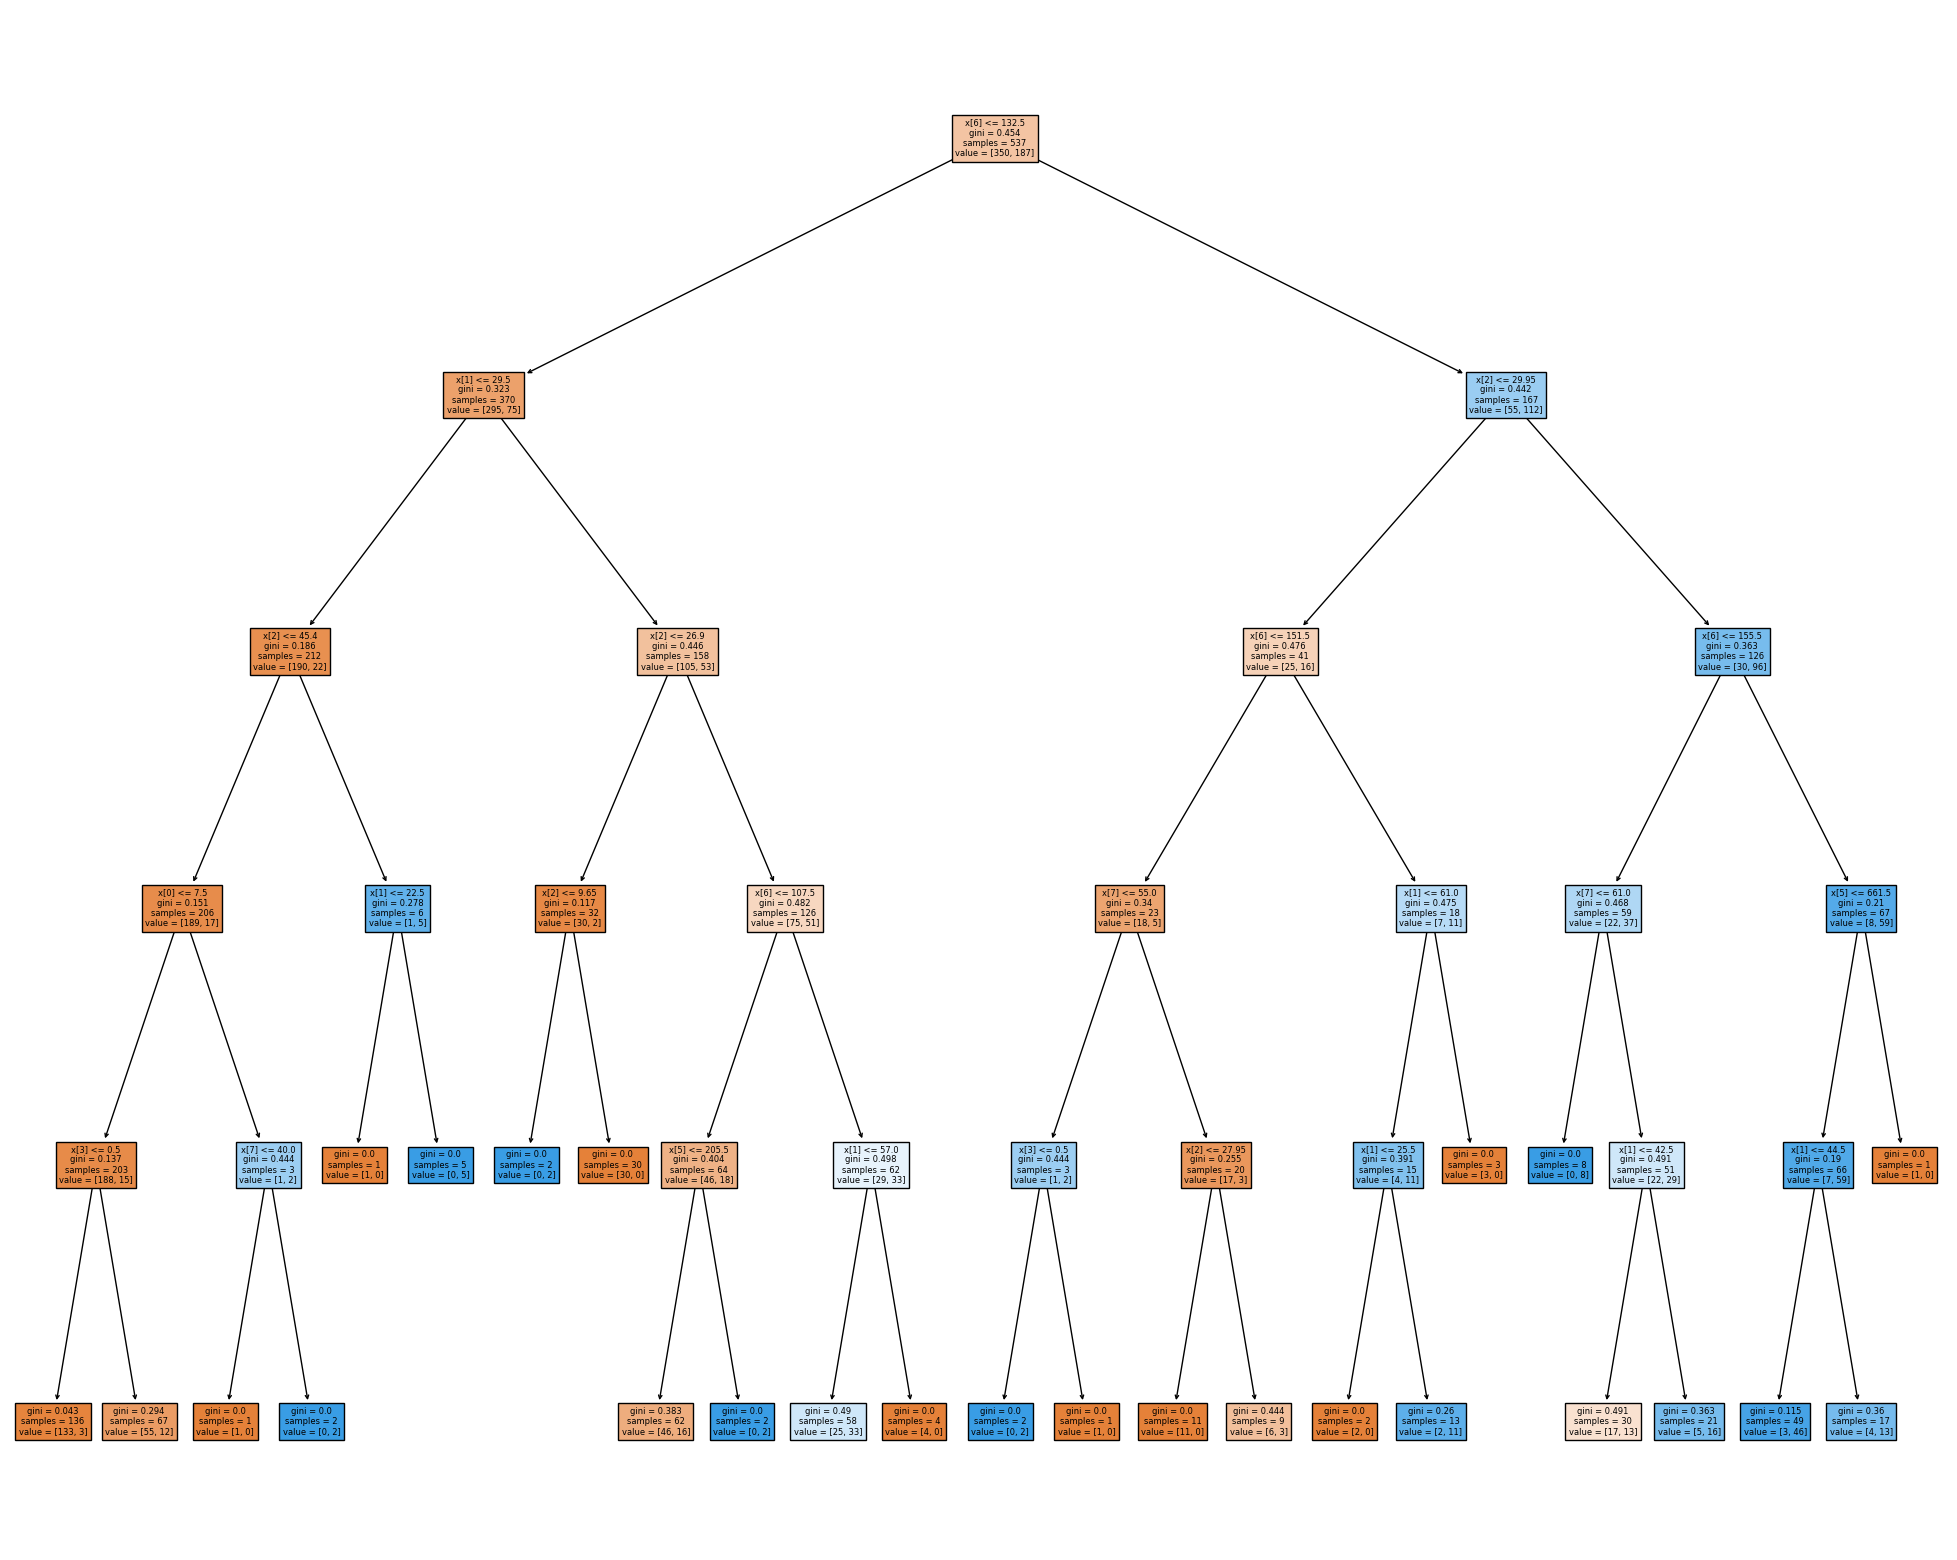

In [82]:
# import necessary library  
from sklearn.tree import plot_tree
  
fig = plt.figure(figsize=(25,20))
dectree_plot = plot_tree(clf_gini, filled=True)

Accuracy on train set: 0.84
Accuracy on test set: 0.82
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       150
           1       0.80      0.64      0.71        81

    accuracy                           0.82       231
   macro avg       0.81      0.78      0.79       231
weighted avg       0.82      0.82      0.81       231

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


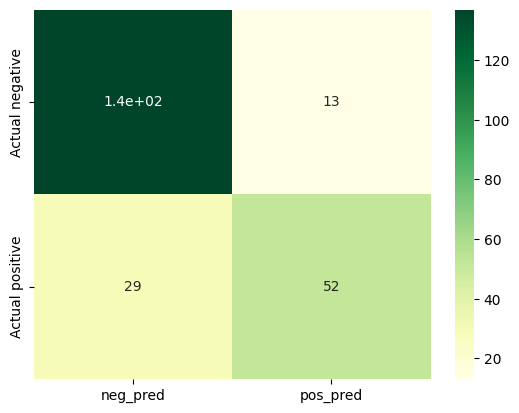

In [133]:
y_pred_train = clf_gini.predict(X_train) 
y_pred = clf_gini.predict(X_test) 
# Convert predicted values to integers
y_pred_train_int = np.round(y_pred_train).astype(int)
y_pred_int = np.round(y_pred).astype(int)

# Print accuracy of our model for test and train set
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train_int), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_int), 2))
print("--------"*10)

# Print classification report of our model 
print(classification_report(y_test, y_pred_int))
print("--------"*10)

print("--------"*10)# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred_int)

# Print confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_int), annot=True, cmap='YlGn', 
yticklabels =['Actual negative', 'Actual positive'], xticklabels =['neg_pred', 'pos_pred']); 

Look similar to dec tree regression, unfortunately again not so great [1] recall

# Scaling:

### Standardization:

In [103]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the data and transform it, the data has to be numeric!
standardized_X_train = scaler.fit_transform(X_train)
# Only transforming and not fitting test-data:
standardized_X_test = scaler.transform(X_test)

# Now the standardized data is stored in a Numpy array
# How to convert the standardized data back to a DataFrame:
standardized_X_train = pd.DataFrame(standardized_X_train)
standardized_X_test = pd.DataFrame(standardized_X_test)

standardized_X_train.head()  

,pregnancies,Age,bmi,pedigree_f,skinthickness,insulin,glucose,bloodpressure
209,0.931383,0.632129,0.431483,-0.749463,0.812564,-0.722392,2.017945,0.780670
176,0.632606,0.716992,-0.119832,-0.749463,-1.316902,-0.722392,-1.148619,0.465388
147,-0.562502,0.038086,-0.209581,1.185449,0.941623,0.373154,-0.476923,-0.270269
454,-0.562502,-0.810548,0.726372,-0.749463,0.489918,0.244266,-0.668836,-0.795739
636,0.333829,1.226172,-0.427543,-0.749463,-1.316902,-0.722392,-0.540894,0.255200


In [104]:
standardized_X_test.head() 

,pregnancies,Age,bmi,pedigree_f,skinthickness,insulin,glucose,bloodpressure
730,-0.263725,0.038086,-0.478828,-0.749463,0.167271,0.004903,0.290729,0.465388
198,0.035052,-0.640821,0.341734,1.185449,1.522386,0.189029,-0.380967,-0.270269
24,2.126492,1.480762,0.572517,-0.749463,0.812564,0.621723,0.706540,1.306139
417,0.035052,0.292676,0.816121,1.185449,0.748035,-0.722392,0.738525,0.675576
387,1.230161,0.971582,1.431542,-0.749463,1.006152,-0.722392,-0.508909,1.621421


### Min-Max Scaling:

In [101]:
from sklearn.preprocessing import MinMaxScaler

import pandas as pd 

# Create a MinMaxScaler object
scaler = MinMaxScaler() 

# Fit the scaler on the data and transform it, the data has to be numeric!
normalized_X_train = scaler.fit_transform(X_train)
# Only transforming and not fitting test-data:
normalized_X_test = scaler.transform(X_test)


# Now the standardized data is stored in a Numpy array
# How to convert the standardized data back to a DataFrame:
normalized_X_train = pd.DataFrame(normalized_X_train)
normalized_X_test = pd.DataFrame(normalized_X_test)

normalized_X_train.head() 

,pregnancies,Age,bmi,pedigree_f,skinthickness,insulin,glucose,bloodpressure
209,0.411765,0.333333,0.529061,0.0,0.550000,0.000000,0.929293,0.688525
176,0.352941,0.350000,0.464978,0.0,0.000000,0.000000,0.429293,0.639344
147,0.117647,0.216667,0.454545,0.5,0.583333,0.159946,0.535354,0.524590
454,0.117647,0.050000,0.563338,0.0,0.466667,0.141129,0.505051,0.442623
636,0.294118,0.450000,0.429210,0.0,0.000000,0.000000,0.525253,0.606557


In [102]:
normalized_X_test.head() 

,pregnancies,Age,bmi,pedigree_f,skinthickness,insulin,glucose,bloodpressure
730,0.176471,0.216667,0.423249,0.0,0.383333,0.106183,0.656566,0.639344
198,0.235294,0.083333,0.518629,0.5,0.733333,0.133065,0.550505,0.524590
24,0.647059,0.500000,0.545455,0.0,0.550000,0.196237,0.722222,0.770492
417,0.235294,0.266667,0.573770,0.5,0.533333,0.000000,0.727273,0.672131
387,0.470588,0.400000,0.645306,0.0,0.600000,0.000000,0.530303,0.819672


# KNN with scaled data:

In [88]:
from sklearn.neighbors import KNeighborsClassifier

With standardized data:

In [115]:
# Train model
knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
knn.fit(standardized_X_train, np.ravel(y_train))

KNeighborsClassifier(metric='euclidean', n_neighbors=10)

Accuracy on train set: 0.78
Accuracy on test set: 0.74
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.89      0.82       150
           1       0.70      0.46      0.55        81

    accuracy                           0.74       231
   macro avg       0.73      0.68      0.68       231
weighted avg       0.73      0.74      0.72       231

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


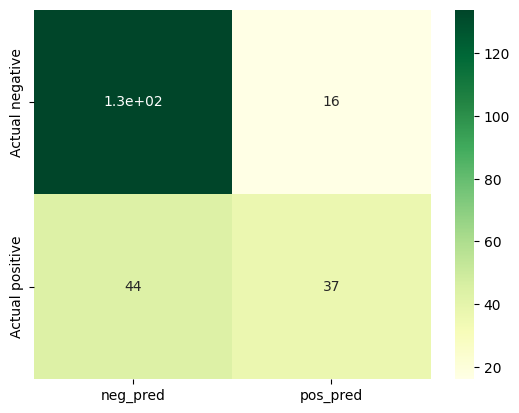

In [116]:
# Predict on train set and test set
y_pred_train = knn.predict(standardized_X_train)
y_pred = knn.predict(standardized_X_test) 


# Print accuracy of our model for test and train set
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred), 2))
print("--------"*10)

# Print classification report of our model 
print(classification_report(y_test, y_pred))  
print("--------"*10) 

print("--------"*10)# Evaluate the model with a confusion matrix 
cm = confusion_matrix(y_test, y_pred) 

# Print confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn', 
yticklabels =['Actual negative', 'Actual positive'], xticklabels =['neg_pred', 'pos_pred']);

Decent accuracy, but terrible [1] recall

With normalized data:

In [ ]:
# Train model
knn = KNeighborsClassifier(n_neighbors=15, metric='euclidean')
knn.fit(normalized_X_train, np.ravel(y_train))

Accuracy on train set: 0.69
Accuracy on test set: 0.68
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.95      0.79       150
           1       0.67      0.17      0.27        81

    accuracy                           0.68       231
   macro avg       0.67      0.56      0.53       231
weighted avg       0.68      0.68      0.61       231

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


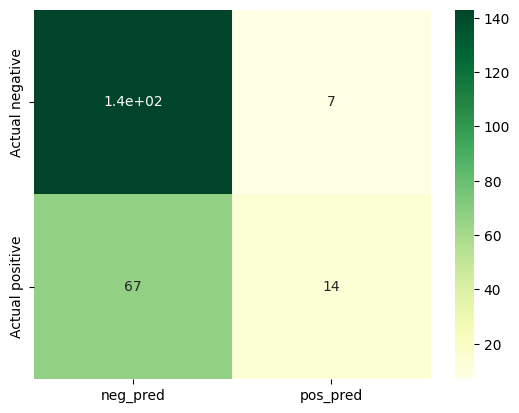

In [123]:
# Predict on train set and test set
y_pred_train = knn.predict(normalized_X_train)
y_pred = knn.predict(normalized_X_test)  


# Print accuracy of our model for test and train set
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred), 2))
print("--------"*10)

# Print classification report of our model 
print(classification_report(y_test, y_pred))
print("--------"*10)

print("--------"*10)# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred) 

# Print confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn', 
yticklabels =['Actual negative', 'Actual positive'], xticklabels =['neg_pred', 'pos_pred']);

Decent accuracy, but terrible [1] recall, predictions are too negative heavy

Testing out KNN with improper workflow of scaling full dataframe (in this case with a copy):

In [121]:
df_copy = df.copy()
df_copy.head()   

,pregnancies,Age,bmi,pedigree_f,outcome,skinthickness,insulin,glucose,bloodpressure
0,6,50,33.6,1,1,35,0,148,72
1,1,31,26.6,0,0,29,0,85,66
2,8,32,23.3,1,1,0,0,183,64
3,1,21,28.1,0,0,23,94,89,66
4,0,33,43.1,2,1,35,168,137,40


In [120]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler on the data and transform it, the data has to be numeric!
normalized_df_copy = scaler.fit_transform(df_copy)

# Now the standardized data is stored in a Numpy array
# How to convert the standardized data back to a DataFrame:
normalized_df_copy = pd.DataFrame(normalized_df_copy)
normalized_df_copy = pd.DataFrame(normalized_df_copy)

normalized_df_copy.head()  

,pregnancies,Age,bmi,pedigree_f,outcome,skinthickness,insulin,glucose,bloodpressure
0,0.352941,0.483333,0.500745,0.5,1.0,0.353535,0.000000,0.743719,0.590164
1,0.058824,0.166667,0.396423,0.0,0.0,0.292929,0.000000,0.427136,0.540984
2,0.470588,0.183333,0.347243,0.5,1.0,0.000000,0.000000,0.919598,0.524590
3,0.058824,0.000000,0.418778,0.0,0.0,0.232323,0.111111,0.447236,0.540984
4,0.000000,0.200000,0.642325,1.0,1.0,0.353535,0.198582,0.688442,0.327869


In [124]:
# Defining X and y again

X = normalized_df_copy.drop('outcome', axis=1)
y = normalized_df_copy['outcome']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

In [125]:
# Train model
knn = KNeighborsClassifier(n_neighbors=15, metric='euclidean')
knn.fit(X_train, np.ravel(y_train)) 

KNeighborsClassifier(metric='euclidean', n_neighbors=15)

Accuracy on train set: 0.79
Accuracy on test set: 0.72
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.74      0.87      0.80       150
         1.0       0.64      0.44      0.53        81

    accuracy                           0.72       231
   macro avg       0.69      0.66      0.66       231
weighted avg       0.71      0.72      0.70       231

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


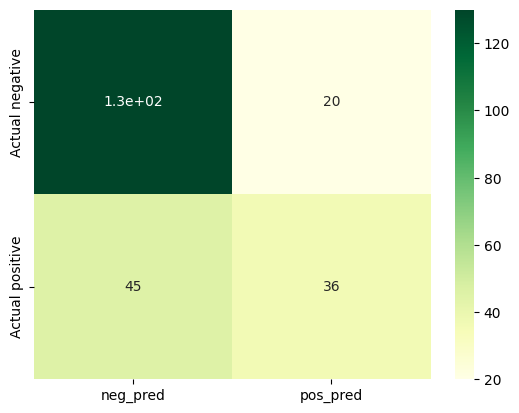

In [126]:
# Predict on train set and test set
y_pred_train = knn.predict(X_train)
y_pred = knn.predict(X_test)   


# Print accuracy of our model for test and train set
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred), 2))
print("--------"*10) 

# Print classification report of our model 
print(classification_report(y_test, y_pred))
print("--------"*10) 

print("--------"*10)# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred) 

# Print confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn', 
yticklabels =['Actual negative', 'Actual positive'], xticklabels =['neg_pred', 'pos_pred']);

Improper data manipulation of scaling all the data does not make a big diffeerence for KNN here, [1] recall is still terrible.